# A first bee/wasp discriminator using the FastAI library

To establish a baseline for future classification efforts, I am going to follow the outline in "Fastbook", the FastAI textbook, available at https://github.com/fastai/fastbook. My first objective is to train a simple and fast model which will classify an uploaded image as either a bee, a wasp, or neither. This is a first step towards an eventual genera classifier. (Note that this notebook must be run with Python 3.9, as this is the latest version supported by PyTorch and, hence, by FastAI.)

In [1]:
import os
import requests
from pathlib import Path
import json
from PIL import Image
import ipywidgets as widgets
from itertools import chain
from fastai.vision.all import *
from fastai.vision.widgets import *

We'll start by downloading basic sample data from a Bing search. This will be good enough for a simple bee/wasp discriminator, but probably not for classifying genera. We use the ```search_bing_images``` function from fastbook.utils.

In [23]:
key = os.environ.get('AZURE_SEARCH_KEY','524859eb34994576b0d53f906e8b30dd')

def search_images_bing(key, term, min_sz=128, total_images=150):    
     max_count = 150
     params = {'q':term, 'license':"public", 'count':max_count, 'min_height':min_sz, 'min_width':min_sz}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = [requests.get(search_url, headers=headers, params=params).json()['value'] for count, offset in (\
                     (max_count if total_images - offset > max_count else total_images - offset,\
                     offset)\
            for offset in range(0,total_images,max_count))]
     return L(chain(*response))


Let's download some images of bees, wasps, and bugs that fit into neither category. We'll need to be a litle careful about what ends up in this ```other``` folder.

In [24]:
classes = ['bee','wasp','other']
for cls in classes:
    path = Path(f'C:/users/mreek/documents/beedata/{cls}')
    path.mkdir(exist_ok=True)
    if cls != 'other':
        results = search_images_bing(key,cls, total_images = 1050)
        download_images(path, urls=results.attrgot('contentUrl'))
    else:
        results = search_images_bing(key,'bug NOT bee NOT wasp', total_images = 1050)
        download_images(path, urls=results.attrgot('contentUrl'))

In [25]:
for cls in classes:
    path = Path(f'C:/users/mreek/documents/beedata/{cls}')
    fns = get_image_files(path)
    failed = verify_images(fns)
    failed.map(Path.unlink)
    print(f"{cls} images: {len(fns)}")

bee images: 1171
wasp images: 926
other images: 1095


Now we can load the images into a DataBlock and take a look at our data. We use ```RandomResizedCrop``` to ensure a variety of views of each bug type.

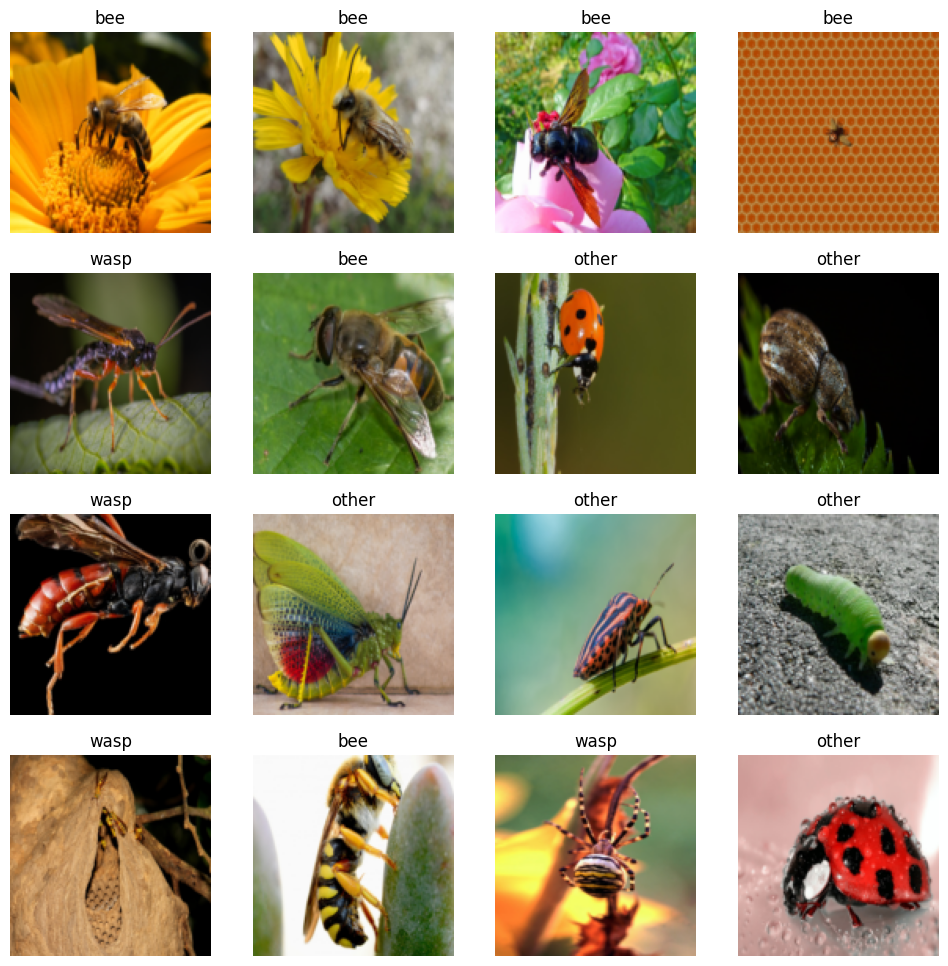

In [27]:

bugs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(128,min_scale=0.3))

dls = bugs.dataloaders(Path('C:/users/mreek/documents/beedata'))
dls.valid.show_batch(max_n=16,nrows=4)
     

This sample looks pretty good. Since we only have ~400 of each image type (which appear to be mainly professional nature photos), we'll apply some standard augmentations to improve the robustness of our model.

Now we'll train a built-in Resnet for classification. We'll use a ```RandomResizedCrop``` with 224px and min scale 0.5.

In [28]:
bugs = bugs.new(item_tfms = RandomResizedCrop(224,min_scale=0.5), batch_tfms = aug_transforms())
dls = bugs.dataloaders(Path('C:/users/mreek/documents/beedata'))

learner = vision_learner(dls, resnet18, metrics = error_rate)
learner.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.334923,0.148496,0.051724,14:31
1,0.250287,0.108468,0.036050,14:34
2,0.166269,0.086506,0.017241,14:37
3,0.104613,0.057427,0.009404,14:52
4,0.076276,0.055242,0.009404,14:01


Let's see what kinds of errors we're making.

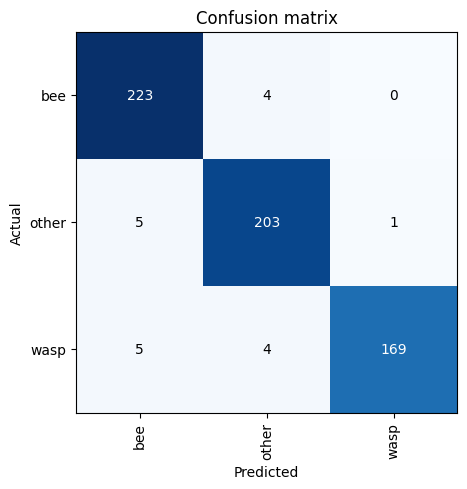

In [38]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

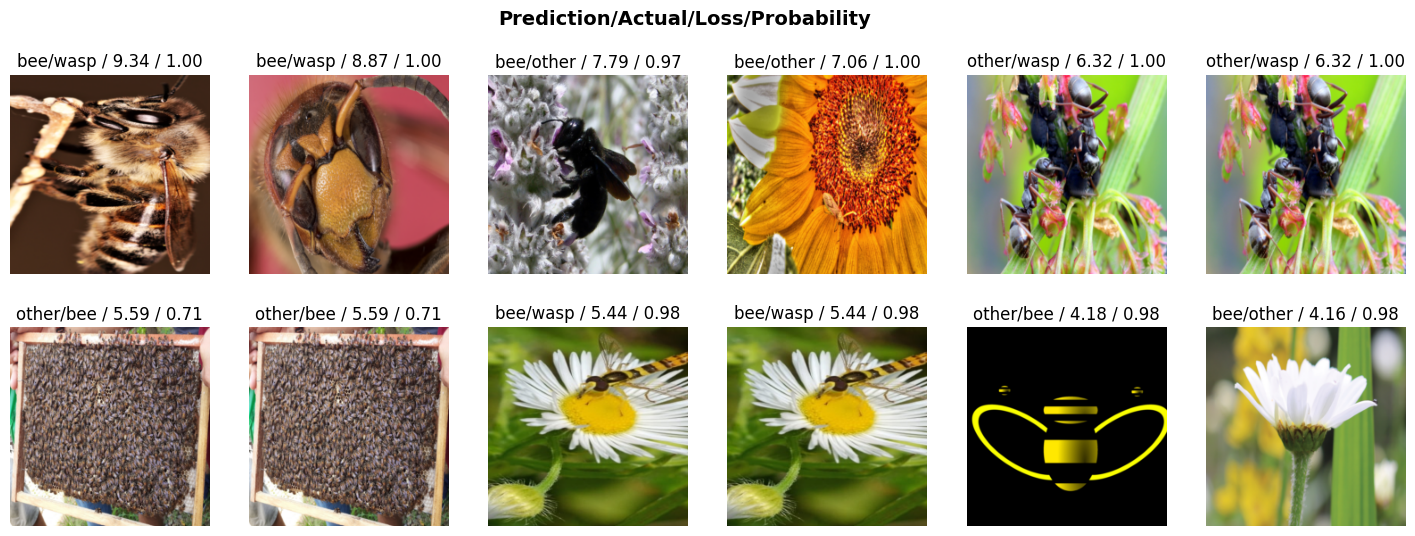

In [40]:
interp.plot_top_losses(12, nrows=2)

For the most part, these errors don't seem to be too worrying. That bug being misclassified as a wasp is a tarnished plant bug (*Lygus lineolaris*), and a particularly colorful example of one (I suspect the original image is oversaturated). The few wasp/bee confusions are a bit worse, but we expect some amount of confusion. These differences might be ironed out when we start looking at genera (since those models will be more sensitive to wasp-like bees and bee-like wasps.)

Next, let's try predicting on a few images I've taken. I expect the jewel bug to be tricky.

In [33]:
data = Path('C:/users/mreek/documents/beetests').glob('*')
cls = []
for file in data:
    cls.append((file,learner.predict(file)))
print(cls)

[(Path('C:/users/mreek/documents/beetests/bee1.jpg'), ('bee', TensorBase(0), TensorBase([9.9999e-01, 7.4903e-08, 7.0376e-06]))), (Path('C:/users/mreek/documents/beetests/bee2.jpg'), ('bee', TensorBase(0), TensorBase([9.9977e-01, 6.6222e-05, 1.6589e-04]))), (Path('C:/users/mreek/documents/beetests/carpenterbee.jpg'), ('wasp', TensorBase(2), TensorBase([2.8730e-02, 3.4015e-05, 9.7124e-01]))), (Path('C:/users/mreek/documents/beetests/jewelbug.jpg'), ('other', TensorBase(1), TensorBase([0.0328, 0.5984, 0.3688]))), (Path('C:/users/mreek/documents/beetests/monarch.jpg'), ('other', TensorBase(1), TensorBase([0.0042, 0.9906, 0.0052]))), (Path('C:/users/mreek/documents/beetests/spider.jpg'), ('wasp', TensorBase(2), TensorBase([5.7955e-07, 2.0988e-06, 1.0000e+00]))), (Path('C:/users/mreek/documents/beetests/wasp1.jpg'), ('wasp', TensorBase(2), TensorBase([5.0944e-04, 1.0097e-01, 8.9852e-01]))), (Path('C:/users/mreek/documents/beetests/wasp2.jpg'), ('wasp', TensorBase(2), TensorBase([0.0270, 0.00

Hmm. Mixed results here. The model was not fooled by the jewel bug or monarch caterpillar, but thought a carpenter bee and a golden orb weaver were wasps and wasn't sure what to make of a mud dauber. These are important species in central PA (and most of the upper US), so maybe I should augment the training data with some specifically chosen images.  

Taking a look at the training data, a few problems become apparent. There are a huge number of yellow garden spiders in the wasp set (I'm guessing this is because yellow garden spiders weave a zigzag pattern in their webs to confuse predatory wasps, a fact which is probably commonly quoted on these pages). The bee folder is also full of clip art and logos that we should get rid of. Let's retrain the model after doing some cleaning.

In [34]:
bugs = bugs.new(item_tfms = RandomResizedCrop(224,min_scale=0.5), batch_tfms = aug_transforms())
dls = bugs.dataloaders(Path('C:/users/mreek/documents/beedata'))

learner = vision_learner(dls, resnet18, metrics = error_rate)
learner.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.320336,0.158434,0.053746,14:55
1,0.199840,0.175451,0.042345,14:53
2,0.135186,0.160012,0.030945,14:52
3,0.091658,0.153274,0.030945,15:26


And let's try those test images again. I'll be happy as long as the model picks up the very clear image of a carpenter bee. 

In [37]:
data = Path('C:/users/mreek/documents/beetests').glob('*')
cls = []
for file in data:
    cls.append((file,learner.predict(file)))
print(cls)

[(Path('C:/users/mreek/documents/beetests/bee1.jpg'), ('bee', TensorBase(0), TensorBase([1.0000e+00, 1.8928e-08, 2.2952e-09]))), (Path('C:/users/mreek/documents/beetests/bee2.jpg'), ('bee', TensorBase(0), TensorBase([9.9990e-01, 4.7357e-05, 5.3248e-05]))), (Path('C:/users/mreek/documents/beetests/carpenterbee.jpg'), ('bee', TensorBase(0), TensorBase([9.4437e-01, 1.0164e-05, 5.5621e-02]))), (Path('C:/users/mreek/documents/beetests/jewelbug.jpg'), ('other', TensorBase(1), TensorBase([0.0198, 0.7228, 0.2574]))), (Path('C:/users/mreek/documents/beetests/monarch.jpg'), ('other', TensorBase(1), TensorBase([0.0052, 0.9215, 0.0733]))), (Path('C:/users/mreek/documents/beetests/spider.jpg'), ('wasp', TensorBase(2), TensorBase([6.3980e-04, 2.2785e-04, 9.9913e-01]))), (Path('C:/users/mreek/documents/beetests/wasp1.jpg'), ('wasp', TensorBase(2), TensorBase([9.0056e-05, 5.4767e-04, 9.9936e-01]))), (Path('C:/users/mreek/documents/beetests/wasp2.jpg'), ('wasp', TensorBase(2), TensorBase([0.0510, 0.021

Well, at least we have the carpenter bee now; the garden spider is not too big of a deal for now. Let's get ready to deploy this first attempt for later reference.

In [6]:
plt = platform.system()
if plt == 'Linux': pathlib.WindowsPath = pathlib.PosixPath
learn_inf.export('bee_inf.save')

In [2]:
learn_inf = load_learner('export.pkl')
learn_inf.predict('C:/users/mreek/documents/beetests/bee1.jpg')

('bee', TensorBase(0), TensorBase([1.0000e+00, 1.8928e-08, 2.2952e-09]))

In [17]:
uploader = widgets.FileUpload(multiple=False)
uploader

FileUpload(value=(), description='Upload')

In [20]:
uploader.value

()